# JWST Time series Observation Wrapper (JTOW) Example

This example uses a super short simulated SUBGRISM256 data set for NIRCam's short-wavelength detector. 

## Import Library

In [1]:
#Import JTOW
from jtow import jtow

#General Imports
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import yaml
import numpy as np
from copy import deepcopy
import pandas as pd

#Download Data 
import urllib
import shutil

#Style Choice
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

1.5.2
Could not import ccdproc, so some CCD-like processing may not work.


## Create a Log Output File 

In [2]:
cwd = os.getcwd() #Get the current working directory 

if (os.path.exists(cwd+'/stpipe-log.cfg') == False): #Generate a log output file in working directory if it doesn't exist
    jtow.log_output('super_short_grism256')

## INPUT: Uncalibrated Raw Data
Exposure raw data products are designated by a file name suffix of “uncal.” These files usually contain only the raw detector pixel values from an exposure, with the addition of some table extensions containing various types of meta data associated with the exposure. The FITS file EXTNAME `SCI` is a 4D array containing the raw pixel values. The first two dimensions are equal to the size of the detector readout, with the data from multiple groups (NGROUPS) within each integration stored along the 3rd axis, and the multiple integrations (NINTS) stored along the 4th axis.

Read More: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html?highlight=uncal#uncalibrated-raw-data-uncal

### Download  the Simulated Test Data

Below is a way to download simulated test data, however one should replace this simulated data for their real raw uncalibratred data.

In [3]:
rawdata_filename_ext = 'jw88888001001_01101_00001_nrca1_uncal.fits' #short-wavelength detector, raw data file name 

data_dir = cwd+'/super_short_grism256_raw_data/' #Output directroy to download data

#Make a directory to store the test data if it doesn't exist
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)
    
rawdata_file = data_dir+rawdata_filename_ext #File for the raw data 

if (os.path.exists(rawdata_file) == False): #if the data is not already downloaded ...
    raw_data = urllib.request.urlopen('https://zenodo.org/record/6688451/files/{}'.format(rawdata_filename_ext)) #Zenodo link
    
    with open('{}'.format(rawdata_filename_ext),'wb') as rawdata_out:
         rawdata_out.write(raw_data.read())
            
    shutil.move(str(rawdata_filename_ext), str(data_dir + '/' + rawdata_filename_ext)) #Save the raw data 
    

## CREATE or READ in the JTOW YAML file

In [4]:
jtow_Params_file = cwd+'/jtow_nrca1_custBias_None_params.yaml' #File for the param file 
if (os.path.exists(jtow_Params_file) == False):
    jtow_Params = {'rawFileSearch': rawdata_file,
                   'outputDir': cwd,
                   'photParam': None,
                   'noutputs': None,
                   'add_noutputs_keyword': False, 
                   'ROEBACorrection': True,
                   'autoROEBAmasks': True,
                   'maxCores': 'quarter',
                   'ROEBAmaskfromRate': None,
                   'ROEBAmaskfromRateThreshold': 0.5,
                   'custBias': None,
                   'saveBiasStep': False,
                   'saveROEBAdiagnostics': False,
                   'jumpRejectionThreshold': 15.0,
                   'ROEBAmaskGrowthSize': None,
                   'saveJumpStep': False,
                   'biasCycle':  None,
                   'biasCycleSearch': None}
                
    #Write the test parameter file
    with open(cwd+'/jtow_nrca1_custBias_None_params.yaml', 'w') as file:
        paramfile = yaml.dump(jtow_Params, file)

In [5]:
#Read in the YAML file
jtow.read_yaml(jtow_Params_file)

{'ROEBACorrection': True,
 'ROEBAmaskGrowthSize': None,
 'ROEBAmaskfromRate': None,
 'ROEBAmaskfromRateThreshold': 0.5,
 'add_noutputs_keyword': False,
 'autoROEBAmasks': True,
 'biasCycle': None,
 'biasCycleSearch': None,
 'custBias': None,
 'jumpRejectionThreshold': 15.0,
 'maxCores': 'quarter',
 'noutputs': None,
 'outputDir': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/JTOW_tests',
 'photParam': None,
 'rawFileSearch': '/home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/JTOW_tests/super_short_grism256_raw_data/jw88888001001_01101_00001_nrca1_uncal.fits',
 'saveBiasStep': False,
 'saveJumpStep': False,
 'saveROEBAdiagnostics': False}

## Create a JTOW object to preform STAGE 1 corrections on

Use help(jtow_obj) to find what functions can be applied to this jtow object. 

In [6]:
#help(jtow_obj) #Find what functions can be applied to this jtow object. 
jtow_obj = jtow.jw(paramFile=jtow_Params_file)

Saving roeba_mask to /home/kglidic/Software/Data_Challenge_Simulation_Pipeline_test/JTOW_tests/diagnostics/jw88888001001_01101_00001_nrca1_roeba_mask.fits


In [7]:
jtow_obj.run_jw() #Run STAGE1 

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Stage 1 Execution Time in Seconds: 13.250996351242065


## OUTPUT: RATEINTS Data

Countrate products are produced by applying the ramp_fitting step to the integrations within an exposure, in order to compute count rates from the original accumulating signal ramps. These products contain 3-D data arrays (found in FITS file EXTNAME SCI), where each plane of the data cube contains the countrate image for a given integration. The results for each integration are also averaged together to form a single 2-D countrate image for the entire exposure. These results are stored in a rate product.

Read More: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html?highlight=uncal#uncalibrated-raw-data-uncal

### Plotting the STAGE 1 Results

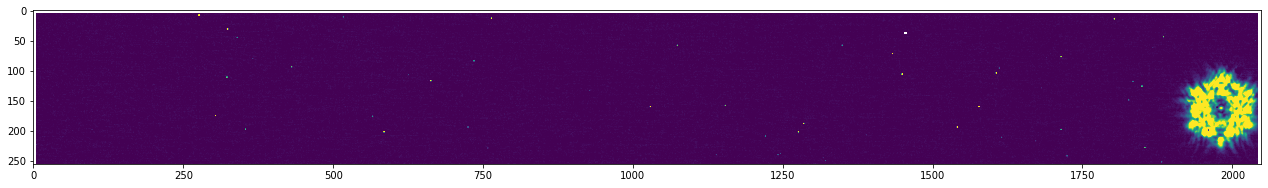

In [8]:
#A check to ensure the star is in the file
file = cwd+'/jw88888001001_01101_00001_nrca1_1_rampfitstep.fits' #random file from the rateints list
HDUList = fits.open(file)
#HDUList.info()

image2D = HDUList[1].data[0]
image2D.shape

fig, ax = plt.subplots(figsize=(22,5))
ax.imshow(image2D, vmin=0, vmax=200)
#ax.set_xlim(900,1200)
plt.show(block=True)